
# Universidade Federal de Santa Catarina
## Programa de Pós-Graduação em Engenharia Elétrica
###  Trabalho 2 - PDSB
### Discentes:

*   Carlos André Antunes
*   João Lucas Pereira dos Santos de Paula
*   Shirley Karolina da Silva Ferreira

Ferramenta utilizada: Google Colaboratory (Colab)

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from array import array
import math
from scipy import signal
from google.colab import files

## Carregando arquivos

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
ecg_df = pd.read_csv('/content/drive/MyDrive/PDSB/ECG and PPG Signals-20231021/ECG_XYZ.txt',sep="\t")
ecg_df

,SamplingInterval,RefChXGain1000Inverted,ChXGain5000,ChYGain5000,ChZGain5000
0,0.0000,0.0403,-0.159,-0.330,-0.424
1,0.0010,0.0516,-0.172,-0.323,-0.436
2,0.0020,0.0473,-0.193,-0.327,-0.438
3,0.0030,0.0320,-0.170,-0.314,-0.447
4,0.0040,0.0339,-0.164,-0.311,-0.477
...,...,...,...,...,...
299106,299.0735,0.0702,-0.336,-0.753,-0.454
299107,299.0745,0.0821,-0.370,-0.750,-0.505
299108,299.0755,0.0827,-0.370,-0.763,-0.557
299109,299.0765,0.0772,-0.349,-0.796,-0.568


### Funções criadas para a resolução dos problemas:

In [38]:
# Função criada para detectar as ondas R
def detecta_R(tempo, sinal, limiar_taxa):
  # diminuindo o limiar_taxa, a onda T é detectada
  # aumentando o limiar_taxa, somente o pico R é detectado

   intervalo = np.max(sinal) - np.min(sinal) # delta_y (escalar)
   limiar = limiar_taxa*intervalo + np.min(sinal) #0.x% do intervalo menos a amplitude negativa (escalar)
   amplitudes_maximas = []
   amplitudes_maximas_indices = []
   picoR_indices = []
   primeira_condicao = False # "chave" pra analisar as amplitudes que ultrapassam o limiar

   for n in range(0,len(sinal)):

    if sinal[n] >=limiar: # se a amplitude ultrapassa o limiar,
      primeira_condicao = True
      amplitudes_maximas.append(sinal[n]) # guardamos os valores dessa amplitude que ultrapassa o limiar
      amplitudes_maximas_indices.append(n) # guardamos os índices dessa amplitude que ultrapassa o limiar

    # analisando agora se esta amplitude se trata de um pico R:
    elif primeira_condicao == True and sinal[n] < limiar: #If the threshold value is crossed the index of the maximum value in the original array is saved
      amplitude_maxima_global = amplitudes_maximas.index(np.max(amplitudes_maximas))

      picoR_indices.append(amplitudes_maximas_indices[amplitude_maxima_global]) # armazena os picos R

      amplitudes_maximas = [] # "zera"
      amplitudes_maximas_indices = [] # "zera"

      primeira_condicao = False # volta à condição inicial
   return picoR_indices

def promediacao(sinal, template, corr_threshold, janela_correlacao, fs, janela_batimento,limiar_amp):
  # ref_menor = np.max(sinal) + np.min(sinal)
  intervalo = np.max(sinal) - np.min(sinal) # delta_y (escalar)
  ref_menor = limiar_amp*intervalo + np.min(sinal)
  samples_window_step = (janela_correlacao/2)*fs/1000 # a cada este passo, a correlação é calculada
  samples_window_size = len(template) # janela de dados do sinal de entrada para calculo da correlação
  numWin = math.floor((len(sinal) - samples_window_size)/samples_window_step +1) # numero de vezes que se janela o sinal de entrada para calculo da correlação

  count_alignments = 0
  count_rejected = 0
  r_alinhado = []
  indexes = []

  for winIdx in range(numWin):

    p1 = int(samples_window_step*winIdx)
    p2 = int(samples_window_size + samples_window_step*winIdx)
    windowed_signal = sinal[p1:p2]
    id = (p1,p2)

    correlacao = np.corrcoef(template, windowed_signal)

    if round(correlacao[0,1],2) > corr_threshold:
      r_possivel = np.max(windowed_signal)
     # if ref_menor < r_possivel:
      if ref_menor < r_possivel:
         r_alinhado.append(r_possivel)
         count_alignments = count_alignments +1
         indexes.append(id)
      else:
        count_rejected = count_rejected +1


  # janela_batimento =0.45
  janela_batimento_samples = janela_batimento*nova_frequencia_amostragem_4000/1000
  x = len(template_samples) + 2*janela_batimento_samples
  sum = np.zeros((int(x)))
  for i in range(0,len(indexes)):
     i1 =indexes[i][0]-janela_batimento_samples
     i2 = indexes[i][1] + janela_batimento_samples
     sum = sum + sinal[int(i1):int(i2)]
  sinal_promediado = sum/count_alignments

  return sinal_promediado, count_alignments, count_rejected

def remove_outliers(data, times=2):
    data = np.array(data)  # Converte para um array NumPy
    mean = np.mean(data)
    std_dev = np.std(data)
    threshold = times * std_dev

    mask = np.abs(data - mean) <= threshold
    filtered_data = data[mask]

    return filtered_data

In [6]:
fs = 1000
T=1/fs
tempo = np.arange(0,len(ecg_df['RefChXGain1000Inverted'])/fs,T)
amplitude_x = ecg_df["ChXGain5000"].to_numpy()
amplitude_y = ecg_df["ChYGain5000"].to_numpy()
amplitude_z = ecg_df["ChZGain5000"].to_numpy()
sinal_referencia = ecg_df['RefChXGain1000Inverted'].to_numpy()*(-1)

Text(0, 0.5, 'Amplitude')

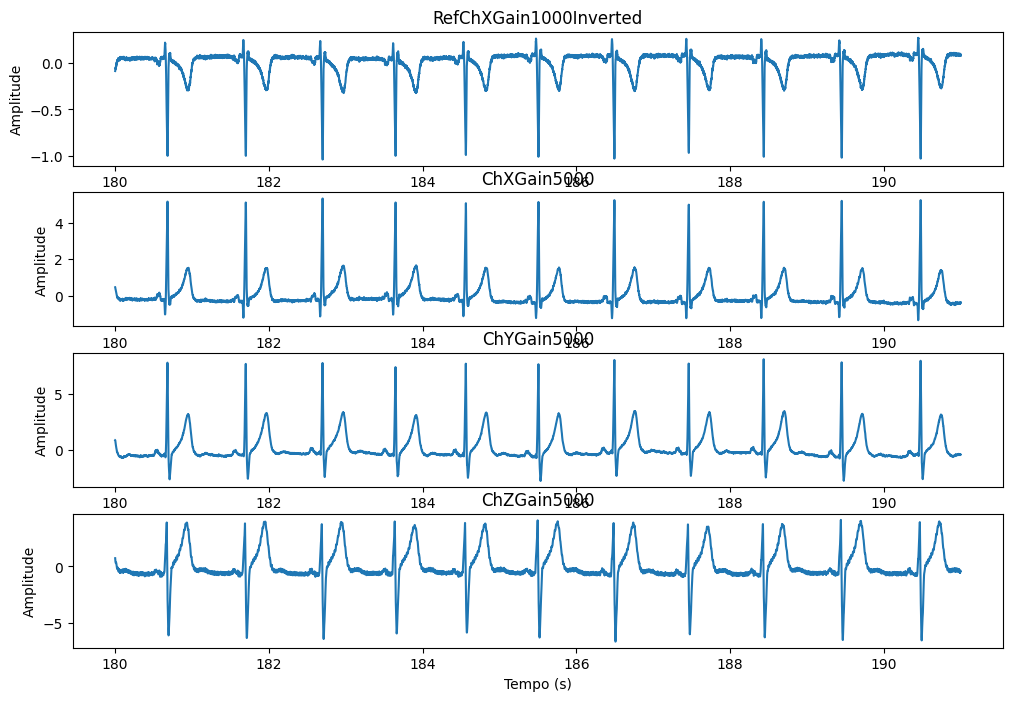

In [7]:
ecg_df.set_index("SamplingInterval",inplace=True)
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
ecg_df['RefChXGain1000Inverted'][180:191].plot(title='RefChXGain1000Inverted')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
ecg_df['ChXGain5000'][180:191].plot(title='ChXGain5000')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 3)
ecg_df['ChYGain5000'][180:191].plot(title='ChYGain5000')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 4)
ecg_df['ChZGain5000'][180:191].plot(title='ChZGain5000')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

# plt.tight_layout()

## (a) Interpole o sinal original para 4000 amostras/segundo. Crie um gráfico para ambos os sinais no intervalo de tempo de 3:00 a 3:10 minutos, marcando as amostras.

In [8]:
# Criar uma função de interpolação
from scipy.interpolate import interp1d

interp_funcao_x = interp1d(tempo, amplitude_x, kind='linear')
interp_funcao_y = interp1d(tempo, amplitude_y, kind='linear')
interp_funcao_z = interp1d(tempo, amplitude_z, kind='linear')
interp_funcao_ref = interp1d(tempo, sinal_referencia, kind='linear')

#### Novas variáveis devido à interpolação

In [9]:
nova_frequencia_amostragem_4000 = 4000 # 1200 Hz

# Gerar novos pontos de tempo para a nova frequência de amostragem
tempo_reamostrado_4000Hz = np.arange(tempo[0], tempo[-1], 1/nova_frequencia_amostragem_4000)

# Interpolar para obter os novos valores de amplitude
amplitude_reamostrada_4000Hz_x = interp_funcao_x(tempo_reamostrado_4000Hz)
amplitude_reamostrada_4000Hz_y = interp_funcao_y(tempo_reamostrado_4000Hz)
amplitude_reamostrada_4000Hz_z = interp_funcao_z(tempo_reamostrado_4000Hz)
amplitude_reamostrada_4000Hz_ref = interp_funcao_ref(tempo_reamostrado_4000Hz)

# criando um dataframe para os canais reamostrados
ecg_interpol = pd.DataFrame({
    "Tempo (s)": tempo_reamostrado_4000Hz,
    "Amplitude X": amplitude_reamostrada_4000Hz_x,
    "Amplitude Y": amplitude_reamostrada_4000Hz_y,
    "Amplitude Z": amplitude_reamostrada_4000Hz_z,
    "Referencia": amplitude_reamostrada_4000Hz_ref
}).set_index('Tempo (s)')

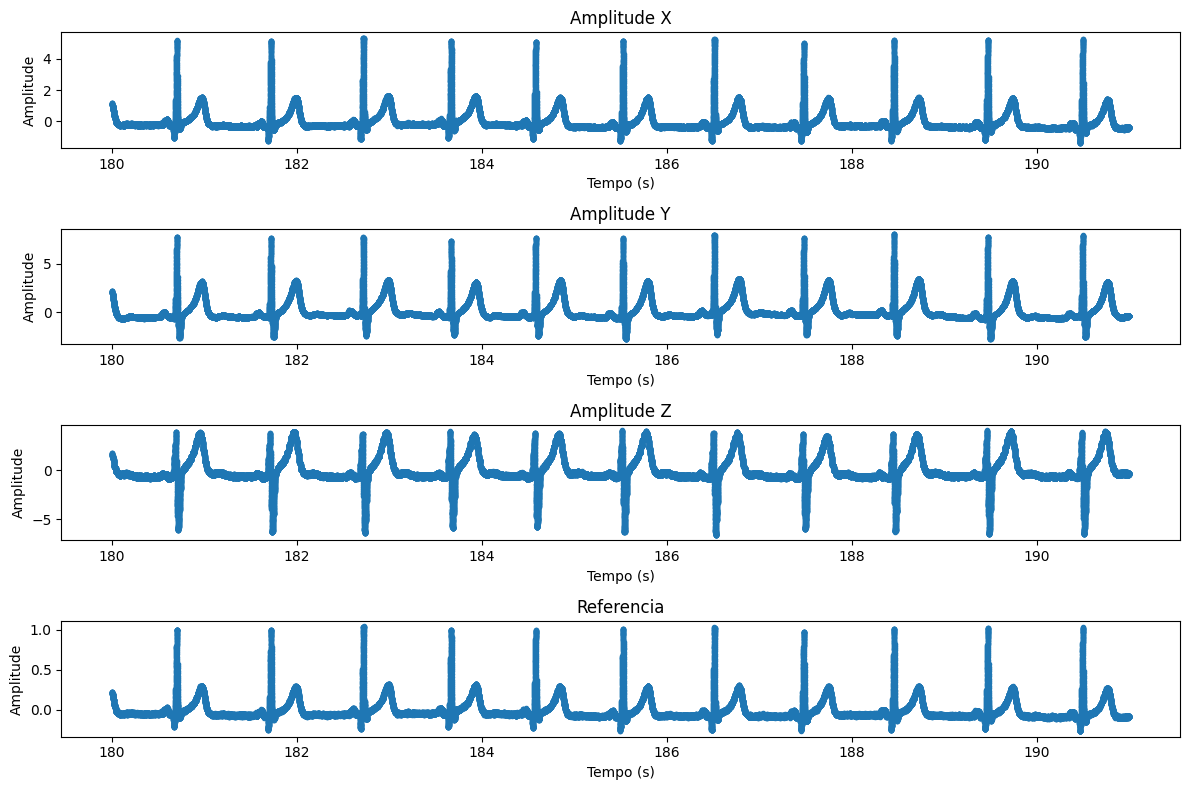

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(4, 1, 1)
ecg_interpol['Amplitude X'][180:191].plot(title='Amplitude X',marker='.')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 2)
ecg_interpol['Amplitude Y'][180:191].plot(title='Amplitude Y',marker='.')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 3)
ecg_interpol['Amplitude Z'][180:191].plot(title='Amplitude Z',marker='.')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.subplot(4, 1, 4)
ecg_interpol['Referencia'][180:191].plot(title='Referencia',marker='.')
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")

plt.tight_layout()

## (b) Desenvolva um algoritmo para detectar cada batimento cardíaco, enquadrar, alinhar e média o complexo PQRST; apresentando o sinal médio, o número de complexos incluídos na média, o número de rejeições, uma estimativa do ruído residual, e calcular o vetor de magnitude usando as seguintes frequências de passa-alta: 25, 40 e 80 Hz.

#### Filtrando o sinal

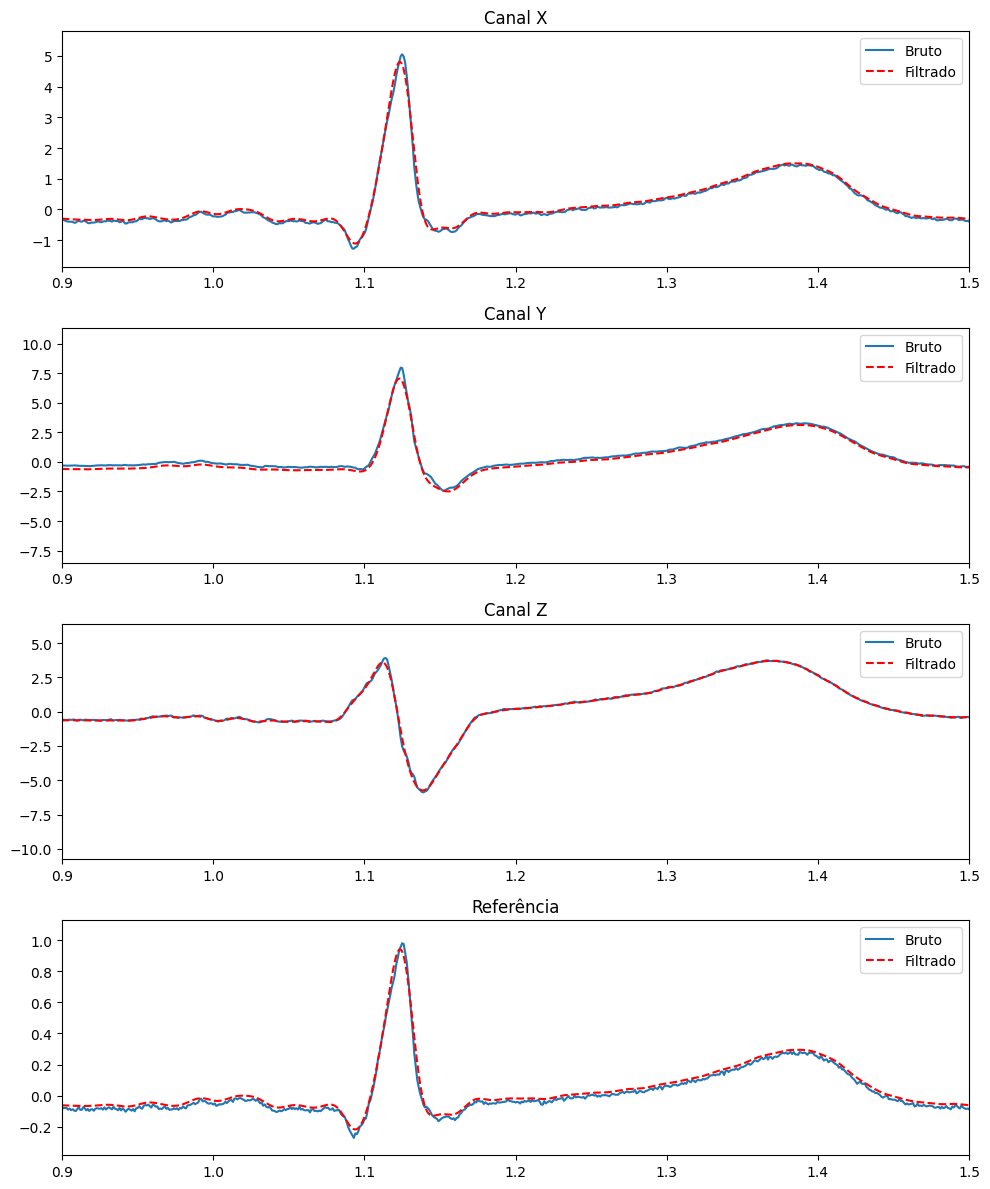

In [11]:
from scipy.signal import butter, filtfilt

# Filtros
cutoff_high = 0.5  # Frequência de corte do filtro passa-alta
cutoff_low = 50  # Frequência de corte do filtro passa-baixa

order_high = 3  # Ordem do filtro passa-alta
order_low = 4  # Ordem do filtro passa-baixa

# Filtro passa-alta
b_high, a_high = butter(order_high, cutoff_high / (4000 / 2), btype='high')
amplitude_reamostrada_4000Hz_x_high = filtfilt(b_high, a_high, amplitude_reamostrada_4000Hz_x)
amplitude_reamostrada_4000Hz_y_high = filtfilt(b_high, a_high, amplitude_reamostrada_4000Hz_y)
amplitude_reamostrada_4000Hz_z_high = filtfilt(b_high, a_high, amplitude_reamostrada_4000Hz_z)
amplitude_reamostrada_4000Hz_ref_high = filtfilt(b_high, a_high, amplitude_reamostrada_4000Hz_ref)

# Filtro passa-baixa
b_low, a_low = butter(order_low, cutoff_low / (4000 / 2), btype='low')
amplitude_reamostrada_4000Hz_x_filtered = filtfilt(b_low, a_low, amplitude_reamostrada_4000Hz_x_high)
amplitude_reamostrada_4000Hz_y_filtered = filtfilt(b_low, a_low, amplitude_reamostrada_4000Hz_y_high)
amplitude_reamostrada_4000Hz_z_filtered = filtfilt(b_low, a_low, amplitude_reamostrada_4000Hz_z_high)
amplitude_reamostrada_4000Hz_ref_filtered = filtfilt(b_low, a_low, amplitude_reamostrada_4000Hz_ref_high)

# Plotagem
plt.figure(figsize=(10, 12))

plt.subplot(4, 1, 1)
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_x, label='Bruto')
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_x_filtered, label='Filtrado',linestyle='dashed', color='red')
plt.title('Canal X')
plt.legend()
plt.xlim(0.9,1.5)

plt.subplot(4, 1, 2)
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_y, label='Bruto')
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_y_filtered, label='Filtrado',linestyle='dashed', color='red')
plt.title('Canal Y')
plt.legend()
plt.xlim(0.9,1.5)

plt.subplot(4, 1, 3)
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_z, label='Bruto')
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_z_filtered, label='Filtrado',linestyle='dashed', color='red')
plt.title('Canal Z')
plt.legend()
plt.xlim(0.9,1.5)

plt.subplot(4, 1, 4)
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_ref, label='Bruto')
plt.plot(tempo_reamostrado_4000Hz, amplitude_reamostrada_4000Hz_ref_filtered, label='Filtrado',linestyle='dashed', color='red')
plt.title('Referência')
plt.legend()
plt.xlim(0.9,1.5)


plt.tight_layout()
plt.show()

### dataframe com o sinal filtrado

In [12]:
ecg_interpol_filtered = pd.DataFrame({
    "Tempo (s)": tempo_reamostrado_4000Hz,
    "Amplitude X": amplitude_reamostrada_4000Hz_x_filtered,
    "Amplitude Y": amplitude_reamostrada_4000Hz_y_filtered,
    "Amplitude Z": amplitude_reamostrada_4000Hz_z_filtered,
    "Referencia": amplitude_reamostrada_4000Hz_ref_filtered
}).set_index('Tempo (s)')

#### Detectando a onda R através da função criada detecta_R() no canal X:



In [13]:
sinal_x = ecg_interpol_filtered['Amplitude X'].to_numpy()
picos_R_x = detecta_R(tempo_reamostrado_4000Hz, sinal_x,0.7)

#### Plotando os picos detectados - Canal X

<Figure size 1200x800 with 0 Axes>

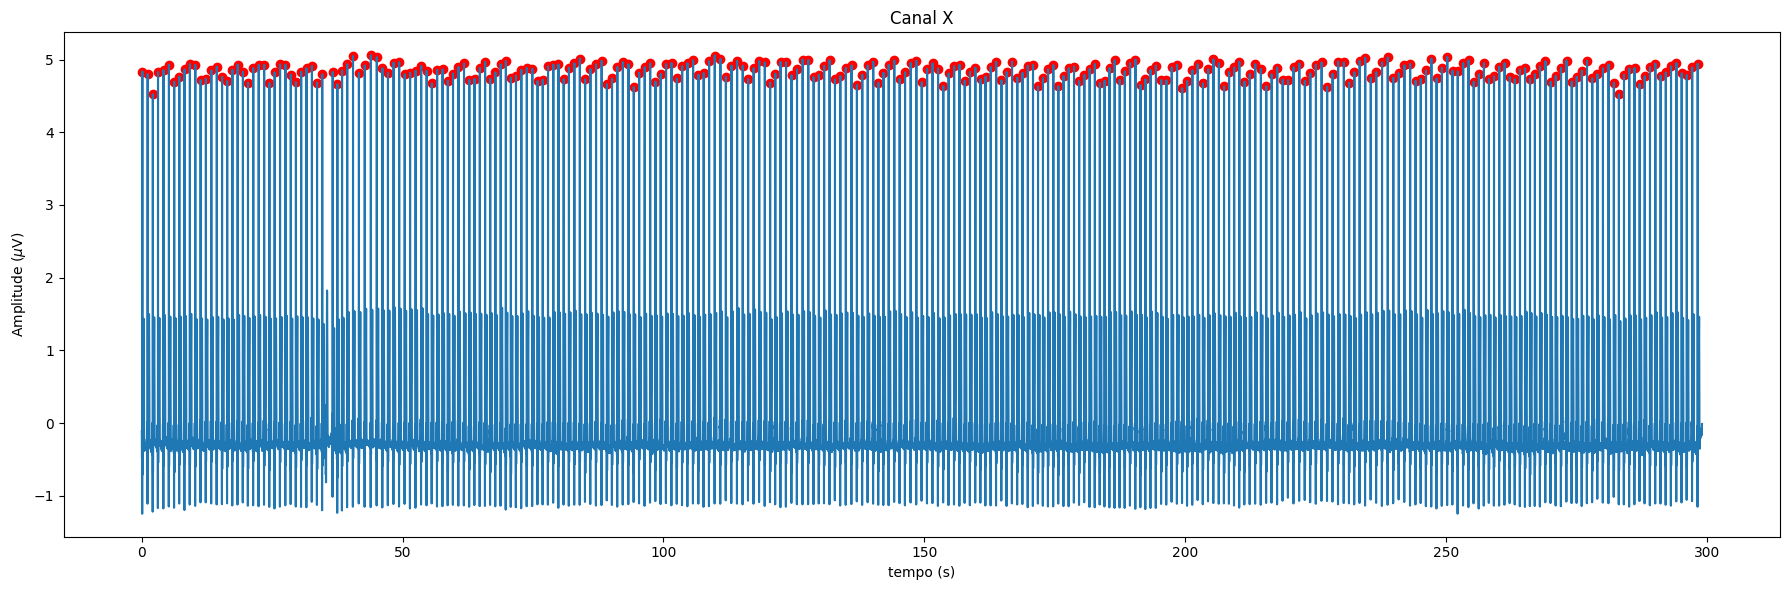

In [14]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(18,6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Canal X')
plt.plot(ecg_interpol_filtered['Amplitude X'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_x], sinal_x[picos_R_x], marker='o',color='r')
plt.tight_layout()

#### Detectando a onda R através da função criada detecta_R() no canal Y:

In [15]:
sinal_y = ecg_interpol_filtered['Amplitude Y'].to_numpy()
picos_R_y = detecta_R(tempo_reamostrado_4000Hz, sinal_y,0.7)

#### Plotando os picos detectados - Canal Y

<Figure size 1200x800 with 0 Axes>

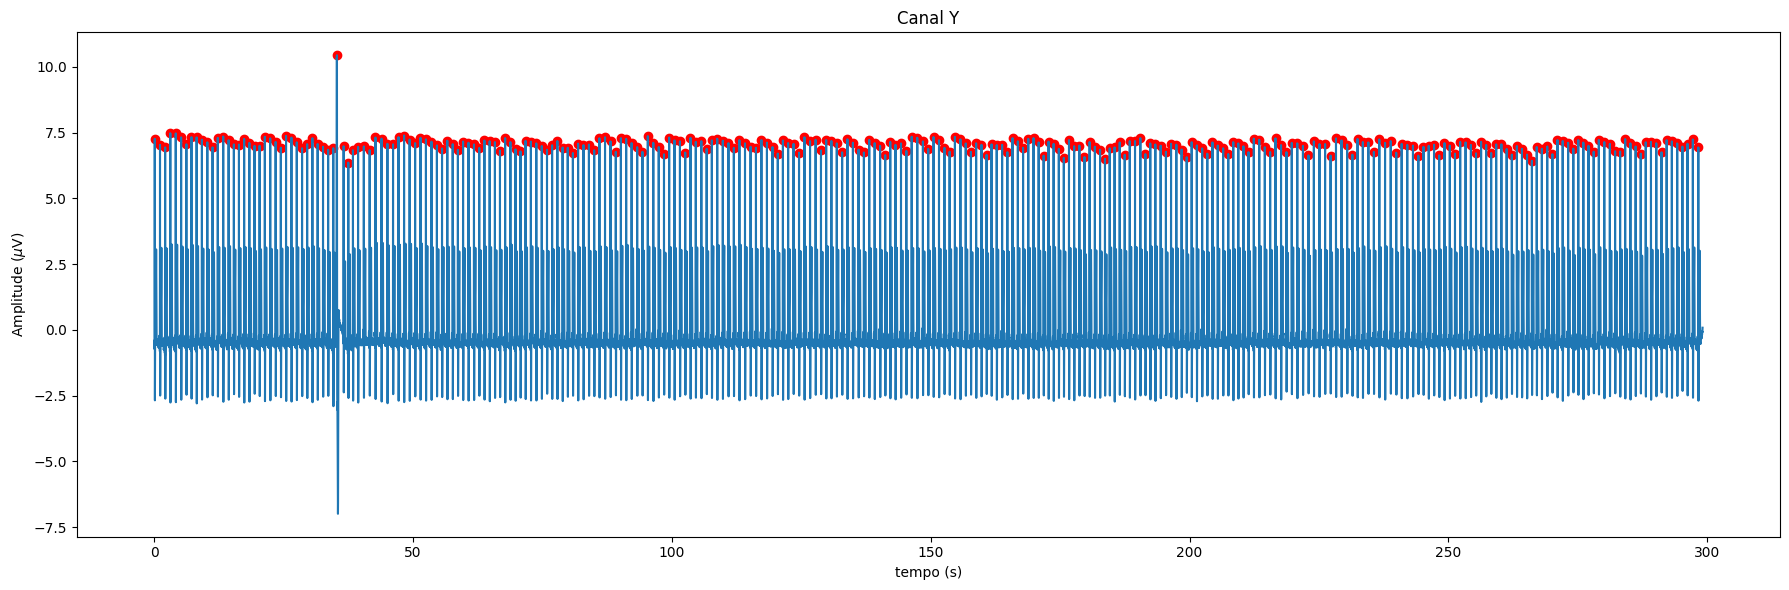

In [16]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(18,6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Canal Y')
plt.plot(ecg_interpol_filtered['Amplitude Y'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_y], sinal_y[picos_R_y], marker='o',color='r')
plt.tight_layout()

#### Detectando a onda R através da função criada detecta_R() no canal z:

In [17]:
sinal_z = ecg_interpol_filtered['Amplitude Z'].to_numpy()
picos_R_z = detecta_R(tempo_reamostrado_4000Hz, sinal_z,0.85)

#### Plotando os picos detectados - Canal Z

<Figure size 1200x800 with 0 Axes>

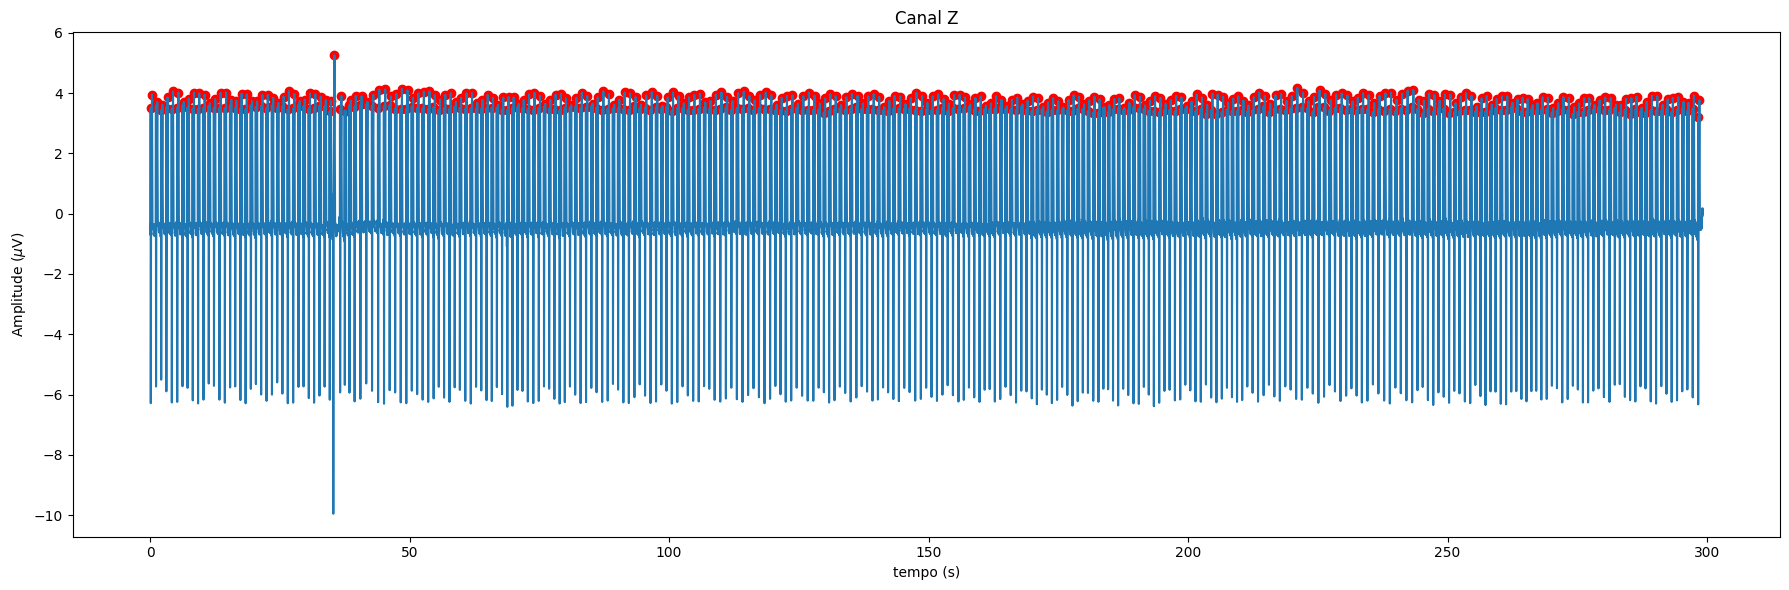

In [18]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(18,6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Canal Z')
plt.plot(ecg_interpol_filtered['Amplitude Z'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_z], sinal_z[picos_R_z], marker='o',color='r')
plt.tight_layout()

#### Detectando a onda R através da função criada detecta_R() no canal de referência:

In [19]:
sinal_referencia = ecg_interpol_filtered['Referencia'].to_numpy()
picos_R_template = detecta_R(tempo_reamostrado_4000Hz, sinal_referencia,0.7)

#### Plotando os picos detectados - Canal de Referencia

<Figure size 1200x800 with 0 Axes>

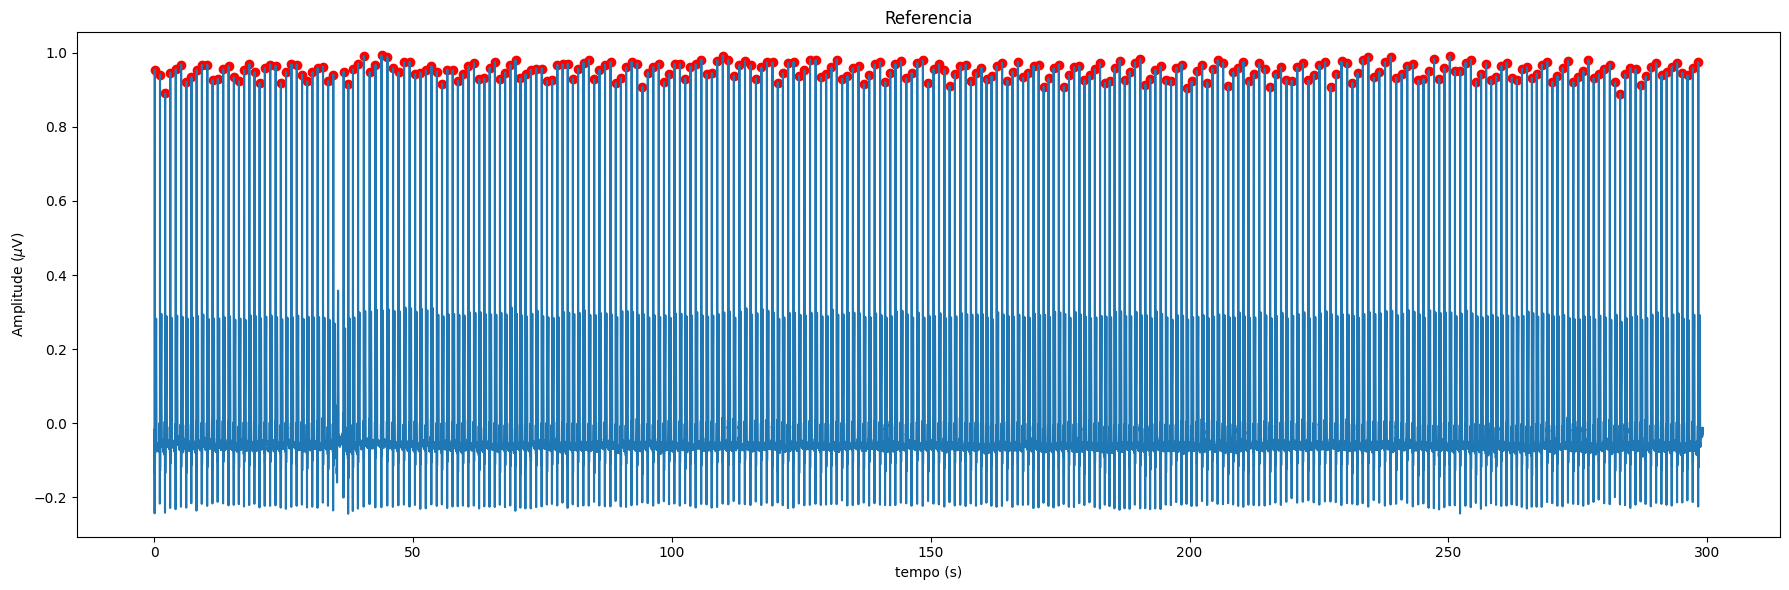

In [20]:
plt.figure(figsize=(12, 8))
plt.figure(figsize=(18,6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Referencia')
plt.plot(ecg_interpol_filtered['Referencia'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_template], sinal_referencia[picos_R_template], marker='o',color='r')
plt.tight_layout()

#### definindo a janela de promediação através da identificação de um template

Text(0, 0.5, 'Amplitude ($\\mu$V)')

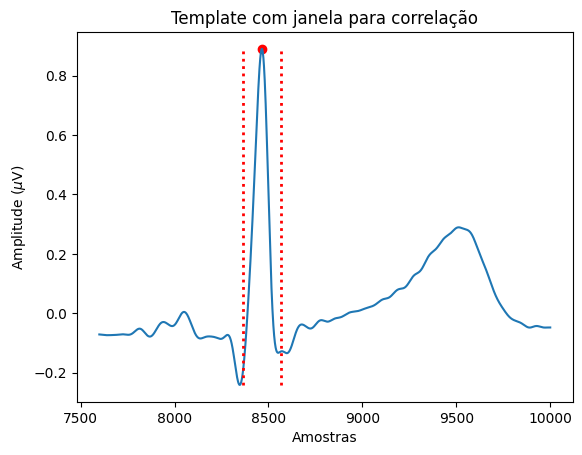

In [21]:
tempo_janela = 25  # milissegundos
janela_amostras = nova_frequencia_amostragem_4000*tempo_janela/1000 # tamanho da janela em amostras
t1 = int(1.9*nova_frequencia_amostragem_4000)
t2 = int(2.5*nova_frequencia_amostragem_4000)

condition1 = int(t1)< np.array(picos_R_template)
condition2 = np.array(picos_R_template) < t2
condition = condition1 & condition2
pico_R_template = np.array(picos_R_template)[condition]


limite_inferior = pico_R_template - janela_amostras
limite_superior = pico_R_template + janela_amostras

sample_interval = range(t1,t2)
plt.plot(sample_interval,sinal_referencia[sample_interval])

plt.vlines(x=limite_inferior, ymin=np.min(sinal_referencia[sample_interval]), ymax=np.max(sinal_referencia[sample_interval]), colors='red', ls=':', lw=2, label='vline_single - full height')
plt.vlines(x=limite_superior, ymin=np.min(sinal_referencia[sample_interval]), ymax=np.max(sinal_referencia[sample_interval]), colors='red', ls=':', lw=2, label='vline_single - full height')
plt.scatter(pico_R_template,np.max(sinal_referencia[sample_interval]), marker='o',color='r')
plt.title('Template com janela para correlação')
plt.xlabel('Amostras')
plt.ylabel('Amplitude ($\mu$V)')

### Promediação do canal X através da função criada promediacao()

In [22]:
# promediacao(sinal, template, corr_threshold, janela_promediacao, fs, janela_batimento)
template_samples = range(int(limite_inferior), int(limite_superior))
template = sinal_referencia[template_samples]
canal_x_promediado, complexos_alinhados, complexos_rejeitados = promediacao(sinal_x, template, 0.8, 50, nova_frequencia_amostragem_4000, 450, 0.7)
print(f'Número de complexos alinhados:{complexos_alinhados}')
print(f'Número de complexos rejeitados:{complexos_rejeitados}')

Número de complexos alinhados:114
Número de complexos rejeitados:159


### Plotando o sinal promediado do canal X

Text(0.5, 1.0, 'Sinal Promediado do Canal X')

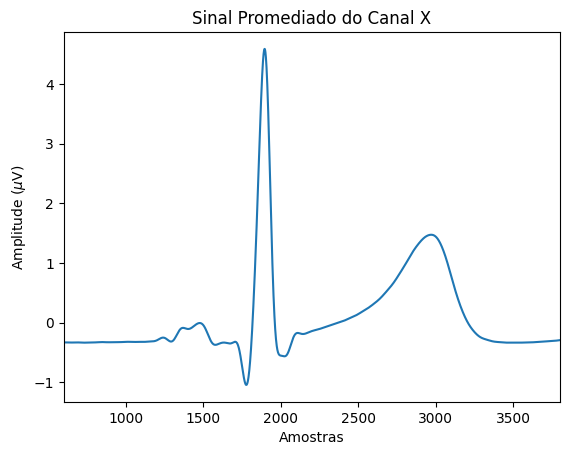

In [23]:
plt.plot(canal_x_promediado)
plt.xlim(600,3800)
plt.xlabel('Amostras')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Sinal Promediado do Canal X')

#### Estimativa do ruído

In [24]:
janela = 20 # ms
janela_samples = janela*nova_frequencia_amostragem_4000/1000
janela_samples
noise = np.std(canal_x_promediado[0:int(janela_samples)])
round(noise,5) # em milivolts

0.00235

### Promediação do canal Y através da função criada promediacao()


In [25]:
canal_y_promediado, complexos_alinhados, complexos_rejeitados = promediacao(sinal_y, template, 0.8, 50, nova_frequencia_amostragem_4000, 450,0.7)
print(f'Número de complexos alinhados:{complexos_alinhados}')
print(f'Número de complexos rejeitados:{complexos_rejeitados}')

Número de complexos alinhados:113
Número de complexos rejeitados:176


Text(0.5, 1.0, 'Sinal Promediado do Canal Y')

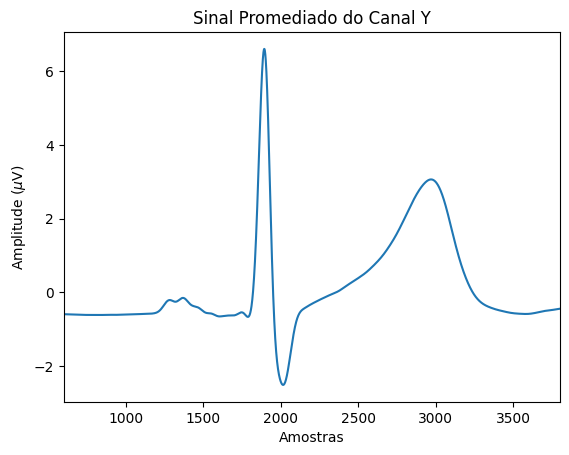

In [26]:
plt.plot(canal_y_promediado)
plt.xlim(600,3800)
plt.xlabel('Amostras')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Sinal Promediado do Canal Y')

### Estimativa do ruído

In [27]:
janela = 20 # ms
janela_samples = janela*nova_frequencia_amostragem_4000/1000
janela_samples
noise = np.std(canal_y_promediado[0:int(janela_samples)])
round(noise,5) # milivolts

0.00795

### Promediação do canal Z através da função criada promediacao()


In [39]:
canal_z_promediado, complexos_alinhados, complexos_rejeitados = promediacao(sinal_z, template, 0.8, 50, nova_frequencia_amostragem_4000, 450,0.9)
print(f'Número de complexos alinhados:{complexos_alinhados}')
print(f'Número de complexos rejeitados:{complexos_rejeitados}')

Número de complexos alinhados:50
Número de complexos rejeitados:173


Text(0.5, 1.0, 'Sinal Promediado do Canal Z')

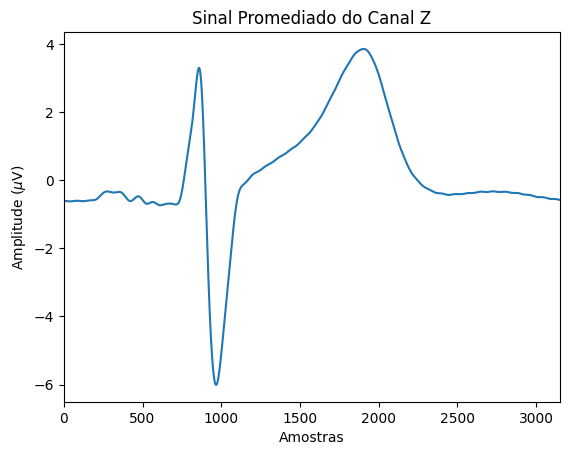

In [40]:
plt.plot(canal_z_promediado)
plt.xlim(0,3150)
plt.xlabel('Amostras')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Sinal Promediado do Canal Z')

### Estimativa do ruído

In [30]:
janela = 20 # ms
janela_samples = janela*nova_frequencia_amostragem_4000/1000
janela_samples
noise = np.std(canal_z_promediado[0:int(janela_samples)])
round(noise,5) # milivolts

0.00644

## (c) Determine todos os intervalos RR consecutivos em milissegundos a partir da gravação e plote RR vs. Tempo.

In [31]:
# Vamos assumir que "picos_R" é um array de índices dos picos R
tempos_picos_R = tempo_reamostrado_4000Hz[picos_R_x]

# Agora, "tempos_picos_R" contém os tempos correspondentes aos picos R
print("Tempos dos picos R:", tempos_picos_R)

rr_intervals = np.diff(tempos_picos_R)

Tempos dos picos R: [1.0900000e-01 1.1235000e+00 2.1160000e+00 3.1117500e+00 4.1632500e+00
 5.2022500e+00 6.2157500e+00 7.1962500e+00 8.1977500e+00 9.2180000e+00
 1.0261250e+01 1.1278250e+01 1.2286000e+01 1.3333750e+01 1.4379750e+01
 1.5392250e+01 1.6373500e+01 1.7376000e+01 1.8378750e+01 1.9386500e+01
 2.0363750e+01 2.1374500e+01 2.2415750e+01 2.3461750e+01 2.4464750e+01
 2.5471250e+01 2.6510000e+01 2.7543750e+01 2.8565250e+01 2.9547000e+01
 3.0558500e+01 3.1578250e+01 3.2614250e+01 3.3601500e+01 3.4595500e+01
 3.6595500e+01 3.7496000e+01 3.8395750e+01 3.9385500e+01 4.0497000e+01
 4.1624000e+01 4.2744500e+01 4.3912750e+01 4.5052500e+01 4.6139750e+01
 4.7194250e+01 4.8271500e+01 4.9345750e+01 5.0405000e+01 5.1438000e+01
 5.2493750e+01 5.3564250e+01 5.4613000e+01 5.5603250e+01 5.6622000e+01
 5.7664750e+01 5.8668500e+01 5.9668250e+01 6.0710750e+01 6.1773750e+01
 6.2789750e+01 6.3789750e+01 6.4806250e+01 6.5820250e+01 6.6797000e+01
 6.7793750e+01 6.8808500e+01 6.9796250e+01 7.0758500e+01 

### Plotando os intervalos RR:

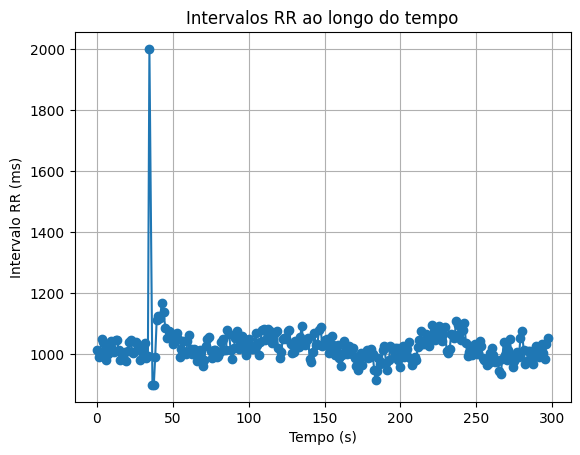

In [32]:
# Plotar os intervalos RR ao longo do tempo
rr_intervals= rr_intervals*1000
plt.plot(tempos_picos_R[:-1] , rr_intervals, marker='o')
plt.title('Intervalos RR ao longo do tempo')
plt.xlabel('Tempo (s)')
plt.ylabel('Intervalo RR (ms)')
plt.grid(True)
plt.show()

## (d) Desenvolva um algoritmo (usando qualquer conteúdo teórico estudado no curso) para a detecção de todos os intervalos QT nos três canais de ECG. Então calcule o QT corrigido (QTc) usando métodos disponíveis na literatura (mas é necessário comparar com a correção de Bazett). Além disso, determine a duração do QRS, o intervalo QT e QTc para o sinal médio.

#### detectando Q e S

In [41]:
# Calculando os índices mínimos
mins_try = []

for R_peak_i in picos_R_x:
    left_interval = sinal_x[R_peak_i-700:R_peak_i]
    right_interval = sinal_x[R_peak_i:R_peak_i+700]

    if left_interval.size > 0:  # se não é vazio
        mins_try.append(R_peak_i - 700 + (list(left_interval).index(min(left_interval))))

    if right_interval.size > 0:  # se não é vazio
        mins_try.append(R_peak_i + (list(right_interval).index(min(right_interval))))

### Plotando os Q e S detectados

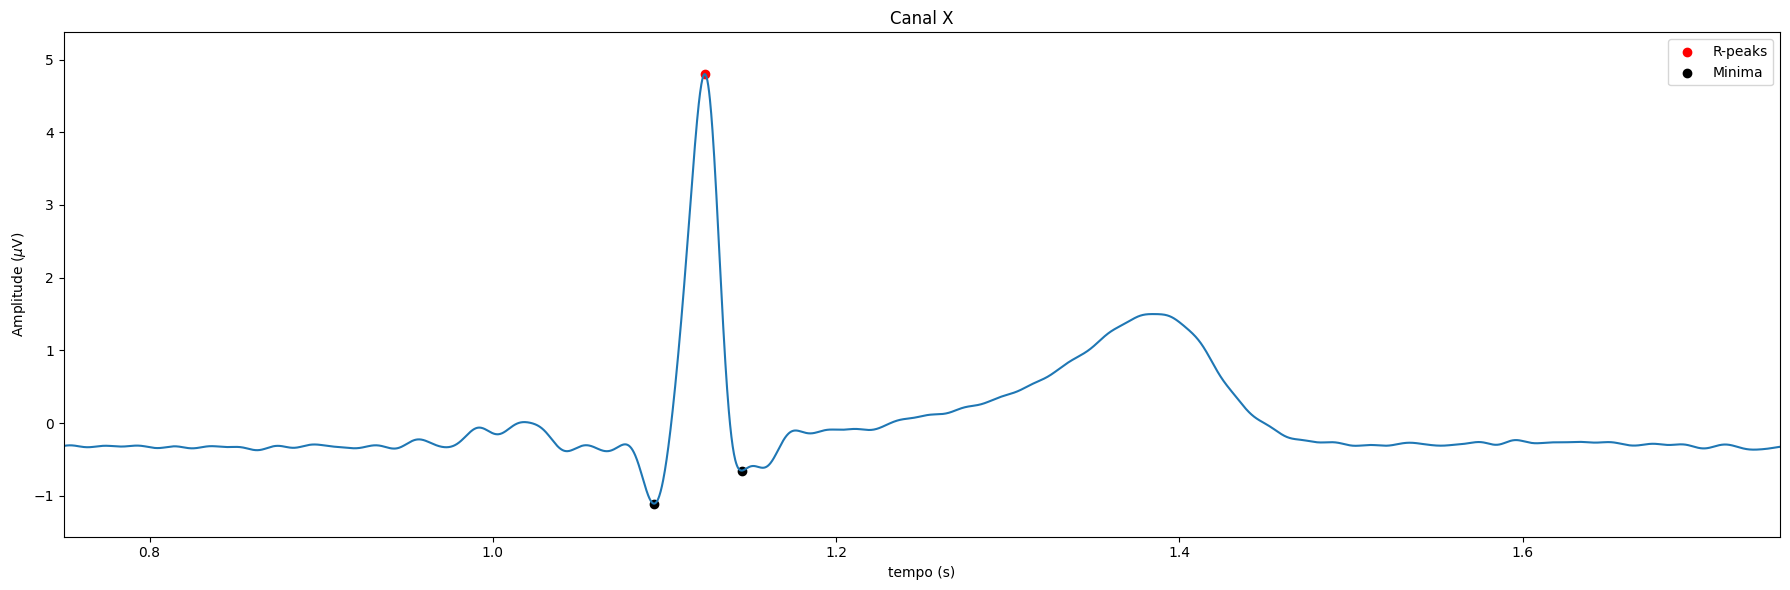

In [34]:
plt.figure(figsize=(18, 6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Canal X')
plt.plot(ecg_interpol_filtered['Amplitude X'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_x], sinal_x[picos_R_x], marker='o', color='r', label='R-peaks')
plt.scatter(tempo_reamostrado_4000Hz[mins_try], sinal_x[mins_try], color='k', label='Minima')
plt.xlim(0.75, 1.75)
plt.legend()
plt.tight_layout()
plt.show()

#### Detectando as ondas P e T

In [35]:
# Mínimos índices
Q_try = []
S_try = []

for R_peak_i in picos_R_x:
    left_interval = sinal_x[R_peak_i-700:R_peak_i]
    right_interval = sinal_x[R_peak_i:R_peak_i+700]

    if left_interval.size > 0:
        Q_try.append(R_peak_i - 700 + (list(left_interval).index(min(left_interval))))

    if right_interval.size > 0:
        S_try.append(R_peak_i + (list(right_interval).index(min(right_interval))))


# adaptando para calcular os maximos em torno de Q e S
P_try = []
T_try = []


q_and_s_waves = Q_try + S_try  # combinando os indices de Q e S

for wave_peak in Q_try:
    left_interval = sinal_x[max(0, wave_peak - 700):wave_peak]

    if left_interval.size > 0:
        P_try.append(wave_peak - 700 + np.argmax(left_interval))

for wave_peak in S_try:
    right_interval = sinal_x[wave_peak:min(len(sinal_x), wave_peak + 1000)]
    if right_interval.size > 0:
        T_try.append(wave_peak + np.argmax(right_interval))

### Plotando o complexo PQRST detectado

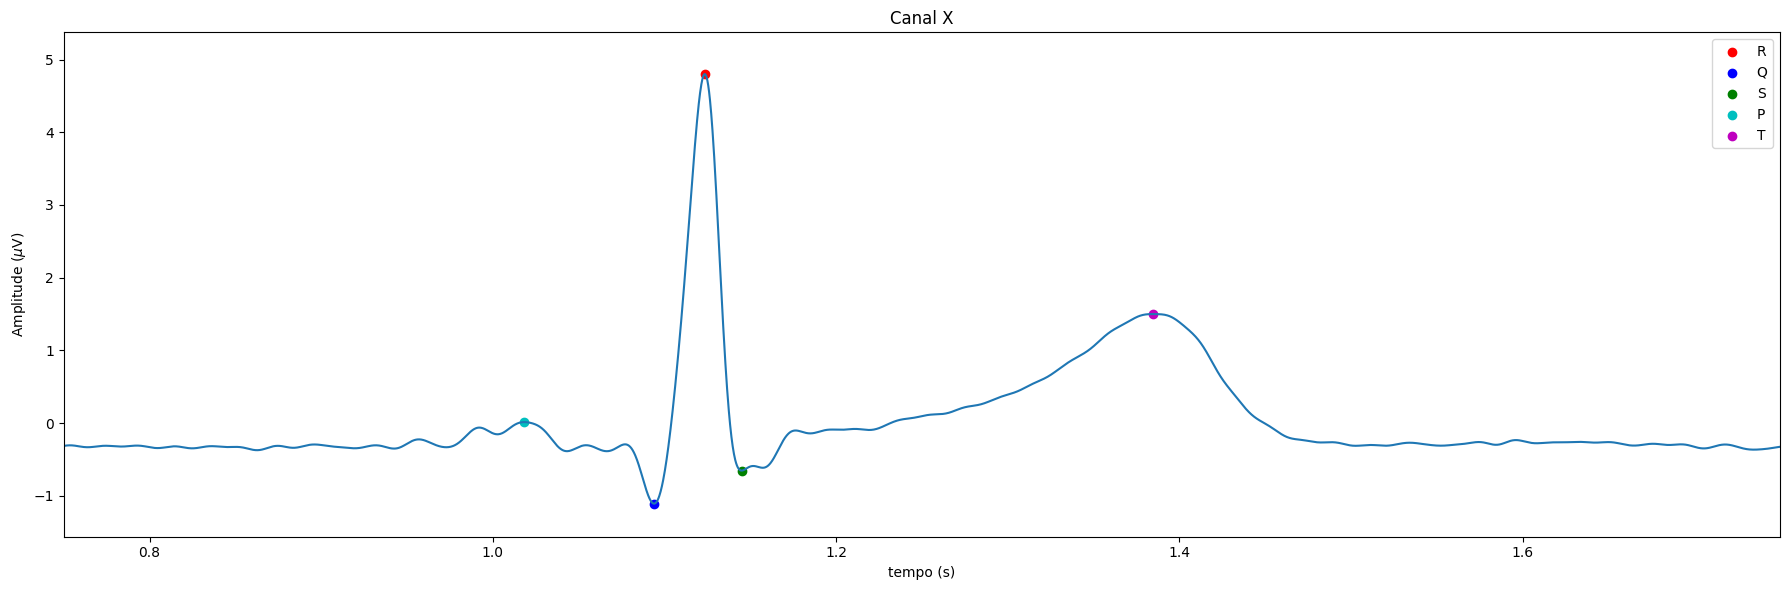

In [36]:
plt.figure(figsize=(18, 6))
plt.xlabel('tempo (s)')
plt.ylabel('Amplitude ($\mu$V)')
plt.title('Canal X')
plt.plot(ecg_interpol_filtered['Amplitude X'])
plt.scatter(tempo_reamostrado_4000Hz[picos_R_x], sinal_x[picos_R_x], marker='o', color='r', label='R')
plt.scatter(tempo_reamostrado_4000Hz[Q_try], sinal_x[Q_try], color='b', label='Q')
plt.scatter(tempo_reamostrado_4000Hz[S_try], sinal_x[S_try], color='g', label='S')
plt.scatter(tempo_reamostrado_4000Hz[P_try], sinal_x[P_try], color='c', label='P')
plt.scatter(tempo_reamostrado_4000Hz[T_try], sinal_x[T_try], color='m', label='T')
plt.xlim(0.75, 1.75)
plt.legend()
plt.tight_layout()
plt.show()

## (e) Calcule a média, desvio padrão, variância e valor RMS para os sinais RR originais e filtrados usando um filtro MA de 3 termos por 5 minutos e em intervalos de 1 minuto para ambos os sinais (considerando os atrasos devido à operação de filtragem).

In [43]:
# Calcular estatísticas descritivas
mean_s = np.mean(rr_intervals)
sdn_s = np.std(rr_intervals)
variancia_s = np.var(rr_intervals)
rms_s = np.sqrt(np.mean(np.square(rr_intervals)))

# Imprimir os resultados
print(f'Média: {round(mean_s,2)} ms')
print(f'Desvio Padrão: {round(sdn_s,2)} ms')
print(f'Variância: {round(variancia_s,2)} (ms^2)')
print(f'RMS: {round(rms_s,2)} ms')

Média: 1024.66 ms
Desvio Padrão: 69.26 ms
Variância: 4796.82 (ms^2)
RMS: 1027.0 ms


### aplicando o filtro MA

In [ ]:
# Aplicar um filtro de média móvel de 3 termos
filtro_MA = np.convolve(rr_intervals, np.ones(3)/3, mode='valid')

# Ajustar o tempo para ter o mesmo comprimento que o resultado do filtro
tempo_filtrado = tempos_picos_R[:len(filtro_MA)]


### Plotando o resultado

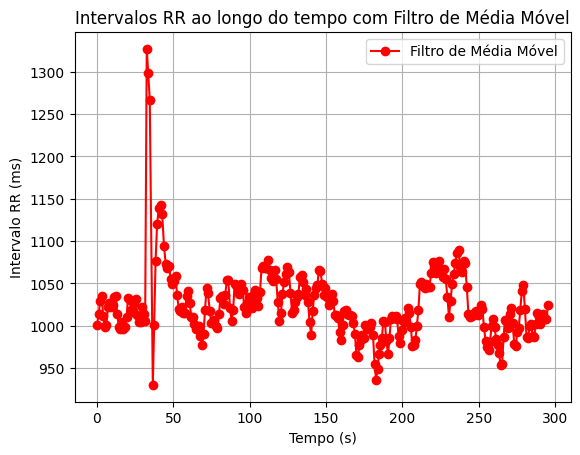

In [44]:
# Plotar os intervalos RR ao longo do tempo e o resultado do filtro MA
plt.plot(tempo_filtrado, filtro_MA, marker='o', color='red', label='Filtro de Média Móvel')
plt.title('Intervalos RR ao longo do tempo com Filtro de Média Móvel')
plt.xlabel('Tempo (s)')
plt.ylabel('Intervalo RR (ms)')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Calcular estatísticas descritivas
mean_m = np.mean(filtro_MA)
sdn_m = np.std(filtro_MA)
variancia_m = np.var(filtro_MA)
rms_m = np.sqrt(np.mean(np.square(filtro_MA)))

# Imprimir os resultados
print(f'Média: {mean_m} ms')
print(f'Desvio Padrão: {sdn_m} ms')
print(f'Variância: {variancia_m} (ms^2)')
print(f'RMS: {rms_m} ms')

Média: 1024.6450403690887 ms
Desvio Padrão: 42.5923402447925 ms
Variância: 1814.1074475281712 (ms^2)
RMS: 1025.529895322657 ms


## (f) Selecione os intervalos RR para a faixa: MRR - 2σ < RR < MRR + 2σ.

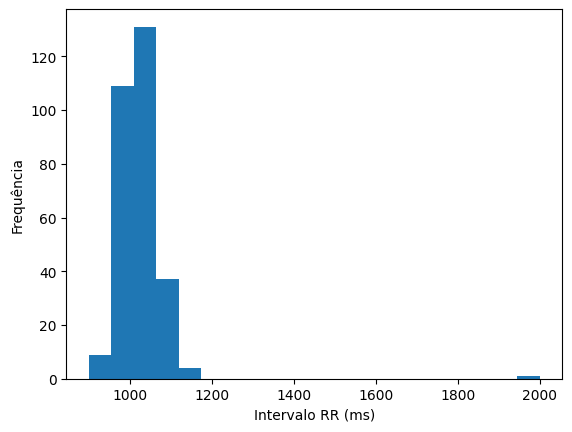

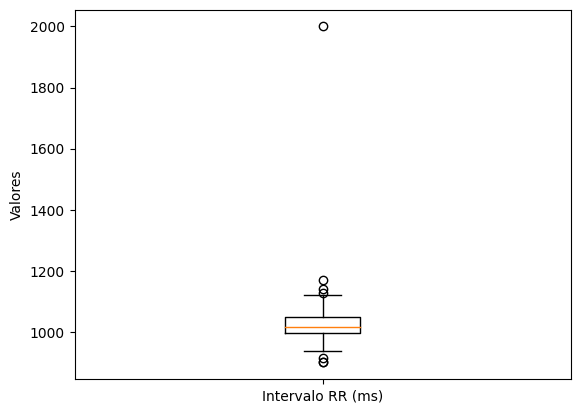

In [ ]:
# Plotar o histograma dos intervalos RR
plt.figure()
plt.hist(rr_intervals, bins=20)
plt.xlabel('Intervalo RR (ms)')
plt.ylabel('Frequência')
plt.show()

# Plotar o Boxplot
fig, ax = plt.subplots()
ax.boxplot(rr_intervals)
ax.set_xticklabels(['Intervalo RR (ms)'])
ax.set_ylabel('Valores')
plt.show()

### removendo os outliers através da função criada remove_outliers():

In [ ]:
intervalos_RR_out = remove_outliers(rr_intervals)

### Plotando o histograma dos intervalos RR sem outliers

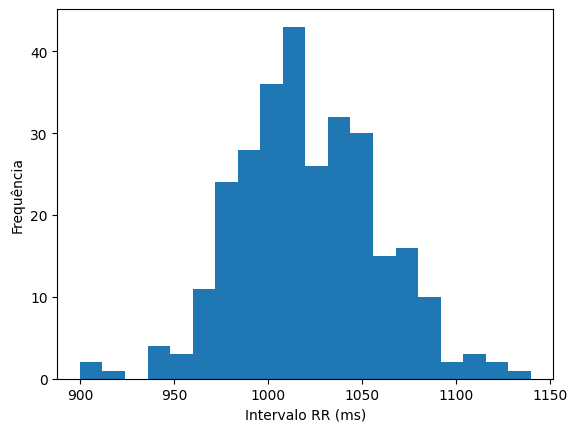

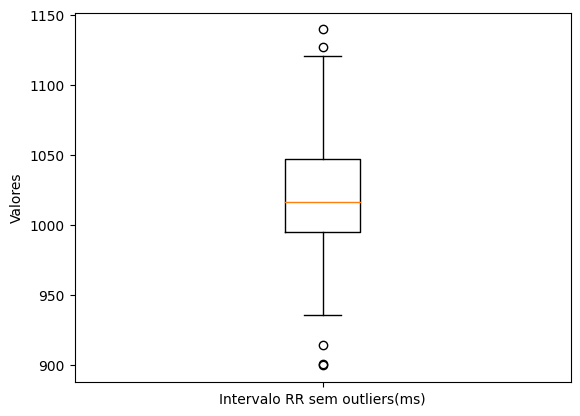

In [ ]:
plt.figure()
plt.hist(intervalos_RR_out, bins=20)
plt.xlabel('Intervalo RR (ms)')
plt.ylabel('Frequência')
plt.show()

# Plotar o Boxplot sem outliers
fig, ax = plt.subplots()
ax.boxplot(intervalos_RR_out)
ax.set_xticklabels(['Intervalo RR sem outliers(ms)'])
ax.set_ylabel('Valores')
plt.show()

#### Plotando o intervalo RR, sem outliers, ao longo do tempo

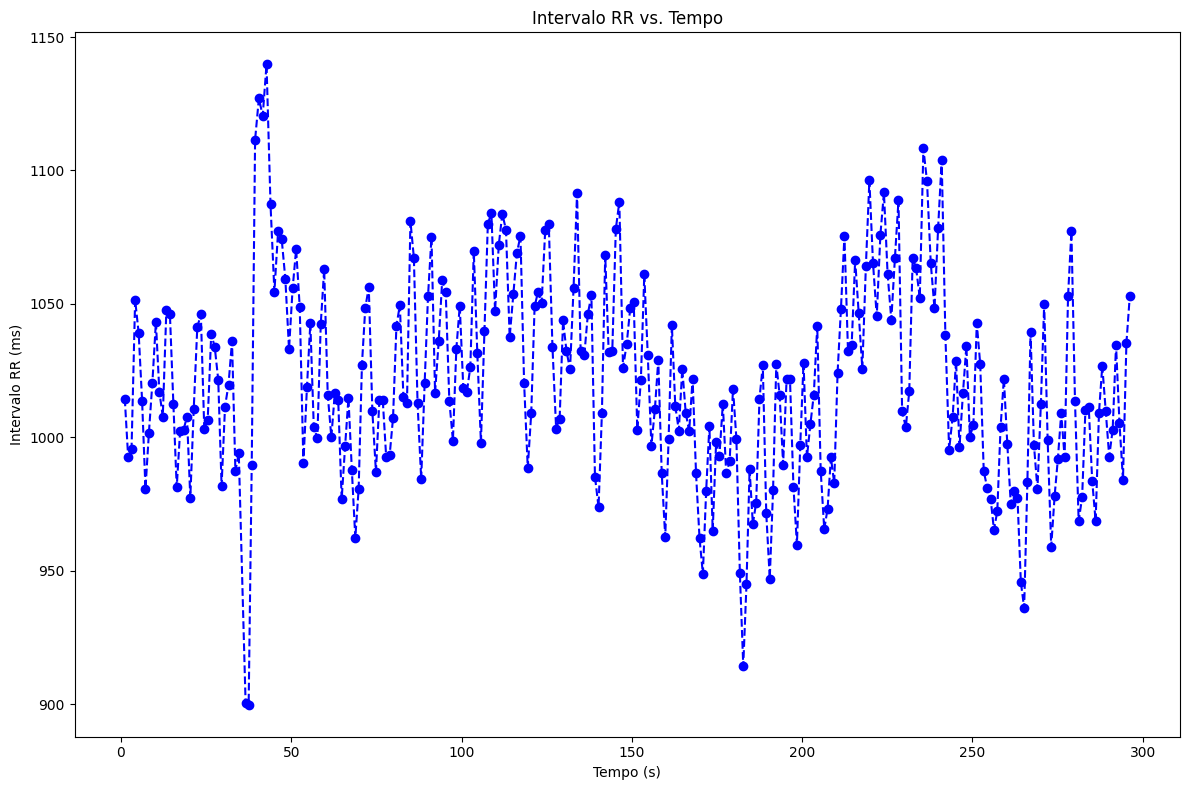

In [ ]:
tempo_ajustado = tempo_reamostrado_4000Hz[picos_R_x[1:len(intervalos_RR_out)+1]]

# Plotando os dados sincronizados
plt.figure(figsize=(12, 8))
plt.xlabel('Tempo (s)')
plt.ylabel('Intervalo RR (ms)')
plt.title('Intervalo RR vs. Tempo')
plt.plot(tempo_ajustado, intervalos_RR_out, marker='o', linestyle='--', color='blue')
plt.tight_layout()
plt.show()

## (g) Calcule o espectro de frequência (ou seja, FFT, AR, outros) da série temporal RR original e da selecionada no item (f), comparando-as.

### Sem outliers

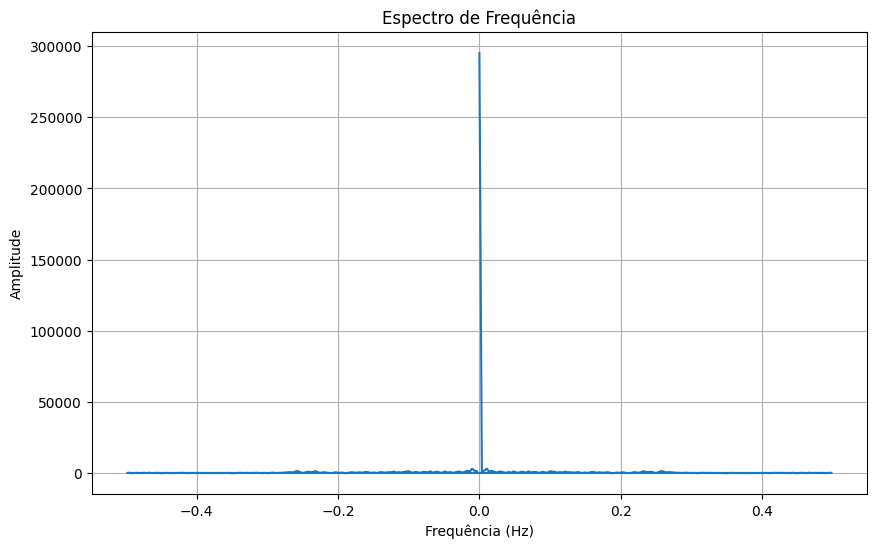

In [ ]:
# Calcular FFT
fft_result = np.fft.fft(intervalos_RR_out)

# Calcular as frequências correspondentes
frequencies = np.fft.fftfreq(len(intervalos_RR_out))

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Espectro de Frequência')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

### com outliers

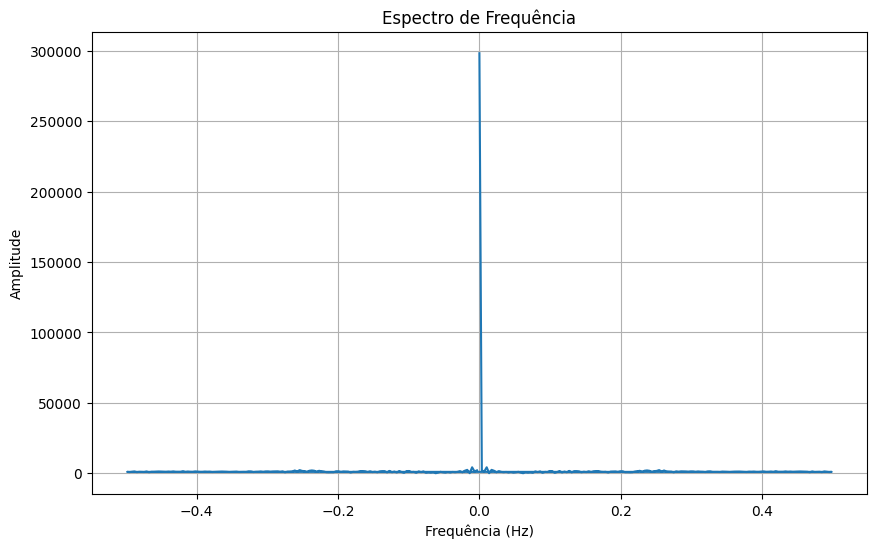

In [ ]:
# Calcular FFT
fft_result = np.fft.fft(rr_intervals)

# Calcular as frequências correspondentes
frequencies = np.fft.fftfreq(len(rr_intervals))

# Plotar o espectro de frequência
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(fft_result))
plt.title('Espectro de Frequência')
plt.xlabel('Frequência (Hz)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()